In [35]:
globals().clear()

import geopandas as gpd
import matplotlib.pyplot as plt
import os
import numpy as np


os.chdir('C:/Users/lbeatty/Documents/Lauren_MIP_Contribution/')

scenario = '26z-thin-debug'
model='SWITCH'

In [36]:
# Read the shapefiles
states = gpd.read_file('tl_2022_us_state/tl_2022_us_state.shp')
states = states[~states['STUSPS'].isin(['AS', 'AK', 'GU', 'MP', 'VI', 'HI', 'PR'])]

emissions_2030 = gpd.read_file('InMap/MIP_InMap_Output/emissions2030_out.shp')

# Transform coordinates to match output
states = states.to_crs(emissions_2030.crs)

In [44]:
#make flag for intersecting land
# Perform spatial intersection
intersects = emissions_2030.geometry.intersects(states.unary_union)
emissions_2030['intersects'] = intersects
emissions_2030 = emissions_2030[emissions_2030['intersects']==True]

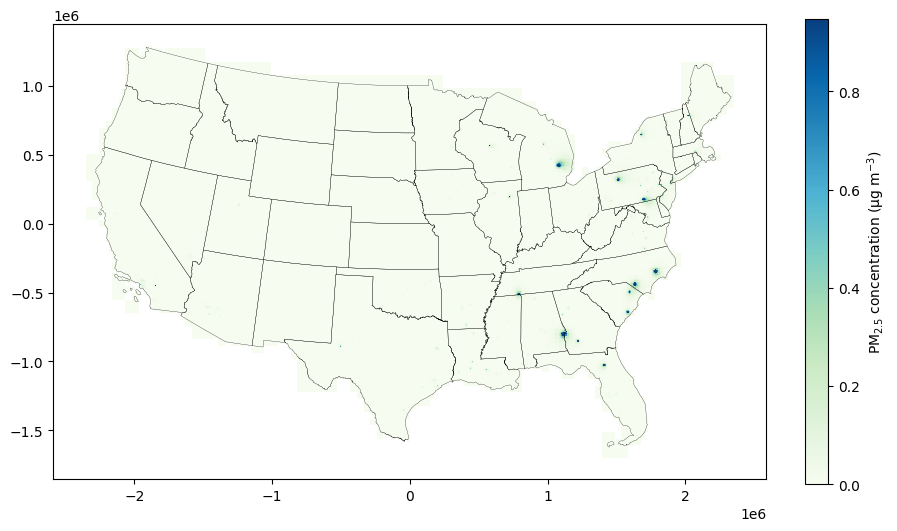

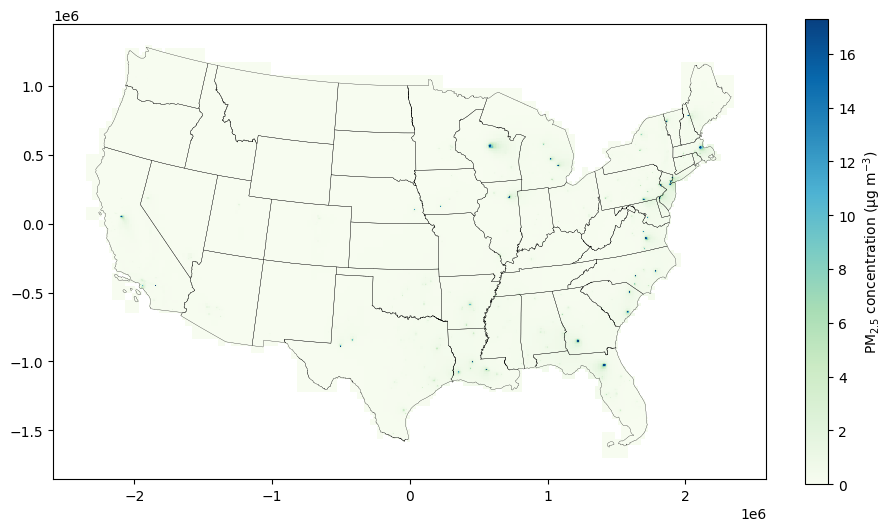

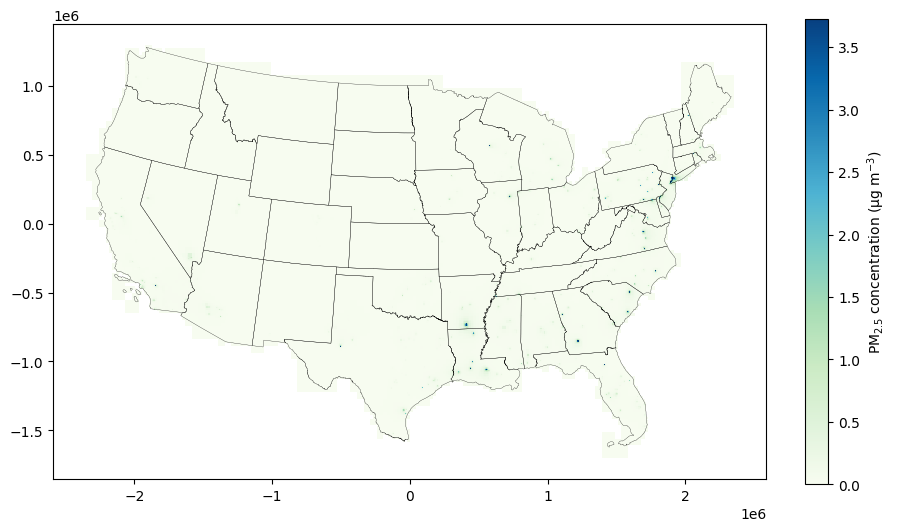

In [48]:
columns_to_plot = ['SOx', 'NOx', 'PrimPM25']

for column in columns_to_plot:
    q = 0.99  # Truncate results at the 99.5th percentile for better visualization
    cut = np.quantile(emissions_2030[column], q)

    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot data with color scale truncated at the specified quantile
    emissions_2030.plot(vmin=0, vmax=cut, cmap="GnBu", column=column, ax=ax)

    # Plot states boundaries
    states.boundary.plot(ax=ax, color='black', linewidth=0.2)

    # Add color bar
    sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=0, vmax=cut))
    sm._A = []  # Fake empty array for the colorbar
    cbar = fig.colorbar(sm, fraction=0.03)  # Adjust the fraction for color bar size
    cbar.set_label('PM$_{2.5}$ concentration (μg m$^{-3}$)')  # Set color bar label

    plt.savefig('MIP_AirPollution/Figures/Output/' + scenario + '/' + model + '/' + column + '.jpg', format='jpg',
                dpi=300, bbox_inches='tight')  # Use bbox_inches='tight' to fit everything within the image boundaries
    plt.show()